<a href="https://colab.research.google.com/github/zakirangwala/esrb-wizard/blob/main/notebooks/workingFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Do Players Prefer Games with Mature Content?**

#1. Data Cleanse & Preprocessing

In [158]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
import ast

## Data Cleanse & Preprocessing

In [159]:
# loading the dataset (originally from https://www.kaggle.com/datasets/fronkongames/steam-games-dataset; had to manually add a comma to separate Discount and DLC)
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/CP322/games.csv" # save to github: notebooks/workingFile.ipynb
steam = pd.read_csv(path, index_col=False)
steam.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,Discount,DLC count,About the game,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [160]:
# First check that all AppID columns are unique in order to ensure no games listed twice
steam = steam.dropna(subset=['AppID', 'Name'])
print("Dataset Dimensions: ", steam.shape)
print("Unique columns in 'AppID': ", steam['AppID'].nunique())
print("Unique columns in 'Name': ", steam['Name'].nunique())

Dataset Dimensions:  (111446, 40)
Unique columns in 'AppID':  111446
Unique columns in 'Name':  110325


We first drop missing rows since they're both unique identifiers and it's not possible to impute those values. Since the shape and the number of unique rows in AppID are exact, we know that we are not double counting a game. But we notice that there are repeat values in name - this is because some games become region-locked and are only avaiable to play in certain countries. In some cases, there are multiple versions that exist so that. Should we cut these?

In [161]:
# Dropping uneccessary columns
steam_drop = steam.drop(['AppID', 'Discount', 'About the game', 'Reviews',
                        'Header image','Tags','Website', 'Support url',
                        'Support email','Metacritic url', 'Score rank', 'Notes',
                        'Developers', 'Screenshots', 'Movies',
                        'Average playtime forever', 'Median playtime forever'
                        ], axis=1)
steam_drop.head()

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,Supported languages,Full audio languages,Windows,...,User score,Positive,Negative,Achievements,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,['English'],[],True,...,0,6,11,30,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports"
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,53,5,12,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie"
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,"['English', 'Portuguese - Brazil']",[],True,...,0,0,0,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy"
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,3,0,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie"
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,"['English', 'Spanish - Spain']",[],True,...,0,50,8,17,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie"


dropping those columns (either it's a unique identifier that we don't need, heavy text based, images of the game, contact information, or ambiguous meaning, or info players would not have access to without Google. Or in the case of discount doesn't impact how a player will play just if they will purchase a game)

In [162]:
steam_drop['release_year'] = (steam_drop['Release date'].str.split(',').str[1]).astype('category')
steam_drop['Required age'] = steam_drop['Required age'].astype('category')
steam_drop = steam_drop.drop(['Release date'], axis=1)
steam_drop.head()

,Name,Estimated owners,Peak CCU,Required age,Price,DLC count,Supported languages,Full audio languages,Windows,Mac,...,Positive,Negative,Achievements,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year
0,Galactic Bowling,0 - 20000,0,0,19.99,0,['English'],[],True,False,...,6,11,30,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008
1,Train Bandit,0 - 20000,0,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,...,53,5,12,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017
2,Jolt Project,0 - 20000,0,0,4.99,0,"['English', 'Portuguese - Brazil']",[],True,False,...,0,0,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021
3,Henosis™,0 - 20000,0,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,...,3,0,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020
4,Two Weeks in Painland,0 - 20000,0,0,0.00,0,"['English', 'Spanish - Spain']",[],True,True,...,50,8,17,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020


XGBoost and Random Forests cannot work with the date directly. Instead, we take the release year (what is usually mentioned when games are discussed. Months and days are rarely relevant)

In [163]:
print("Unique columns in 'Estimated owners': ", steam_drop['Estimated owners'].nunique())
#print(steam_drop['Estimated owners'].unique())

owners_mapping = {
    '0 - 0': 0,
    '0 - 20000': 10000,
    '20000 - 50000': 35000,
    '50000 - 100000': 75000,
    '100000 - 200000': 150000,
    '200000 - 500000': 350000,
    '500000 - 1000000': 750000,
    '1000000 - 2000000': 1500000,
    '2000000 - 5000000': 3500000,
    '5000000 - 10000000': 7500000,
    '10000000 - 20000000': 15000000,
    '20000000 - 50000000': 35000000,
    '50000000 - 100000000': 75000000,
    '100000000 - 200000000': 150000000
}

steam_drop['midpoint_estimated_owners'] = steam_drop['Estimated owners'].map(owners_mapping)
steam_drop= steam_drop.drop(['Estimated owners'], axis=1) # we have a better column now

print("Unique columns in 'midpoint_estimated_owners': ", steam_drop['midpoint_estimated_owners'].nunique())
#print(steam_drop['midpoint_estimated_owners'].unique())
print("Dataframe size after taking midpoint of estimated owner size range", steam_drop.shape)

Unique columns in 'Estimated owners':  14
Unique columns in 'midpoint_estimated_owners':  14
Dataframe size after taking midpoint of estimated owner size range (111446, 23)


Using a midpoint for the estimated number of ownsers gives a much better representation for what the sales look like compared to have categorical values.

In [164]:
print("Unique columns in 'Required age': ", steam_drop['Required age'].nunique())
#print(steam_drop['Required age'].unique())

def age_mapping(x):
  if 0 <= x < 10         : return 0
  elif 10 <= x < 13      : return 10
  elif 13 <= x < 17      : return 13
  elif x >= 17           : return 17


steam_drop['esrb_age']=steam_drop['Required age'].apply(age_mapping)
steam_drop= steam_drop.drop(['Required age'], axis=1).astype('category') # we have a better column now

print("Unique columns in 'esrb_age': ", steam_drop['esrb_age'].nunique())
print("Dataframe size after transforming age categories to match ESRB recommended ages", steam_drop.shape)

Unique columns in 'Required age':  19
Unique columns in 'esrb_age':  4
Dataframe size after transforming age categories to match ESRB recommended ages (111446, 23)


Using the ESRB ratings ages instead because in practice, most people would recommend games via these ages and not super specific ones. Most people would say good for a child, pre-teen, teen or adult. No need to consider the AO since most retailers want their games to be able to be sold in any storefront and AO ratings prevent this.

In [165]:
print("Dataframe size before dropping non-english games", steam_drop.shape)

steam_drop = steam_drop[steam_drop['Supported languages'].apply(lambda x: 'English' in x)]
steam_drop = steam_drop.drop(['Supported languages'], axis=1) # no longer need it if all games are english

print("Dataframe size after dropping non-english games", steam_drop.shape)

steam_drop = steam_drop[steam_drop['Full audio languages'].apply(lambda x: (len(x) == 2 or 'English' in x))]
# if we make this 0, we could have 40000 rows of only english voice acting games

steam_drop['voice_acting'] = steam_drop['Full audio languages'].apply(lambda x: 0 if len(x) == 2 else 1).astype('category')
# 0 means no, 1 means yes it has voice acting
steam_drop = steam_drop.drop(['Full audio languages'], axis=1)

print("Dataframe size after dropping games that have audio exclusively in another language", steam_drop.shape)
steam_drop.tail()

Dataframe size before dropping non-english games (111446, 23)
Dataframe size after dropping non-english games (99911, 22)
Dataframe size after dropping games that have audio exclusively in another language (97272, 22)


,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,esrb_age,voice_acting
111447,Paragon Of Time,0,2.99,0,True,False,False,0,0,5,...,0,0,0,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie",2025,10000,0,0
111448,A Few Days With : Hazel,0,2.69,0,True,False,False,0,0,0,...,0,0,0,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",2025,10000,0,0
111449,MosGhost,0,7.99,0,True,False,False,0,0,24,...,0,0,0,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,2025,10000,0,0
111450,AccuBow VR,0,0.00,0,True,False,False,0,0,0,...,0,0,0,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",2025,0,0,1
111451,Defense Of Fort Burton,0,9.99,0,True,False,False,0,0,0,...,0,0,0,Ledx,"Single-player,Steam Achievements,Steam Cloud,S...","Action,Casual,Strategy,Early Access",2025,10000,0,1


Being a North American independent rating company, ESRB usually only rates English games. Thus, we are interested in looking at games that support both English text and only games that either have English voice acting or no voice acting (audio we transform into a categorical value on if it contains voice acting or not). Plus, there have only ever been 24 games ever given the AO rating (https://en.wikipedia.org/wiki/List_of_AO-rated_video_games)

In [166]:
boolean_mapping = {
    True: 1,
    False: 0
}

steam_drop['Windows'] = steam_drop['Windows'].map(boolean_mapping).astype('category')
steam_drop['Mac'] = steam_drop['Mac'].map(boolean_mapping).astype('category')
steam_drop['Linux'] = steam_drop['Linux'].map(boolean_mapping).astype('category')

steam_drop.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,esrb_age,voice_acting
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,10000,0,0
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,10000,0,0
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021,10000,0,0
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020,10000,0,0
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020,10000,0,0


In [167]:
# Attempting to show the relationship between how many reviews are positive vs negative in a game
steam_drop['Positive'] = steam_drop['Positive'].astype(int)
steam_drop['Negative'] = steam_drop['Negative'].astype(int)
steam_drop['%_positive_reviews'] = ((steam_drop['Positive'])/(steam_drop['Positive']+ steam_drop['Negative']) * 100).fillna(0)
steam_drop.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,esrb_age,voice_acting,%_positive_reviews
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,10000,0,0,35.294118
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,10000,0,0,91.379310
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021,10000,0,0,0.000000
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020,10000,0,0,100.000000
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020,10000,0,0,86.206897


In [168]:
# Working to transform categorical list columns via multilabel encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Working with the Genres
steam_drop['Genres'] = steam_drop['Genres'].astype(object)
genres = steam_drop[['Name','Genres']].copy()
genres['Genres'] = genres['Genres'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

genres_encoded = pd.DataFrame(mlb.fit_transform(genres['Genres']),columns=mlb.classes_, index=genres.index)
genres = pd.concat([genres[['Name']], genres_encoded], axis=1)
genres['Free to Play'] = (genres['Free to Play'] != 0) | (genres['Free To Play'] != 0)
genres = genres.drop(['Free To Play'], axis=1) # we had duplicate columns

# Working with the Categories
steam_drop['Categories'] = steam_drop['Categories'].astype(object)
categories = steam_drop[['Name','Categories']].copy()
categories['Categories'] = categories['Categories'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

categories_encoded = pd.DataFrame(mlb.fit_transform(categories['Categories']),columns=mlb.classes_, index=categories.index)
categories = pd.concat([categories[['Name']], categories_encoded], axis=1)

# Merging new datasets back into the Steam dataset
steam_encoded = pd.merge(steam_drop, genres, on='Name', how='inner')
steam_encoded = pd.merge(steam_encoded, categories, on='Name', how='inner')
steam_encoded = steam_encoded.drop(['Genres', 'Categories'], axis=1)
steam_encoded.head()

#genres_encoded.columns.tolist()
#categories_encoded.columns.tolist()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,Tracked Motion Controller Support,VR Only,VR Support,VR Supported,Valve Anti-Cheat enabled
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,0,0,0,0,0,0,0,0


Well we wanted to create encoding to see if any of the genres or categories play an important role. But they were original strings. We had to first convert to arrays by splitting on the comma, and then transforming each unique value into a column. There's so many here... maybe we drop the ones that don't make sense

## Feature Engineering

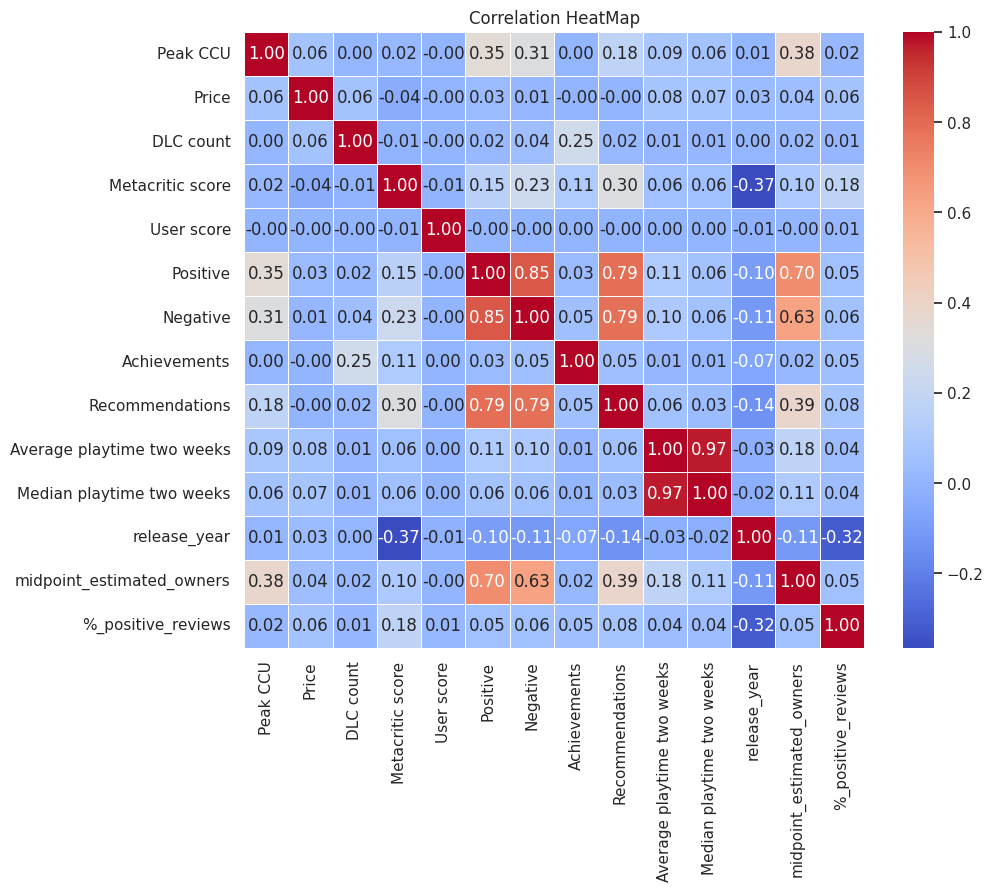

In [169]:
# Testing for Multicolinearity on Numerical Columns
steam_numerical = steam_encoded[['Peak CCU','Price','DLC count','Metacritic score',
                                 'User score','Positive','Negative','Achievements',
                                 'Recommendations','Average playtime two weeks',
                                 'Median playtime two weeks','release_year',
                                 'midpoint_estimated_owners','%_positive_reviews']]

correlation_matrix = steam_numerical.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation HeatMap')
plt.show()

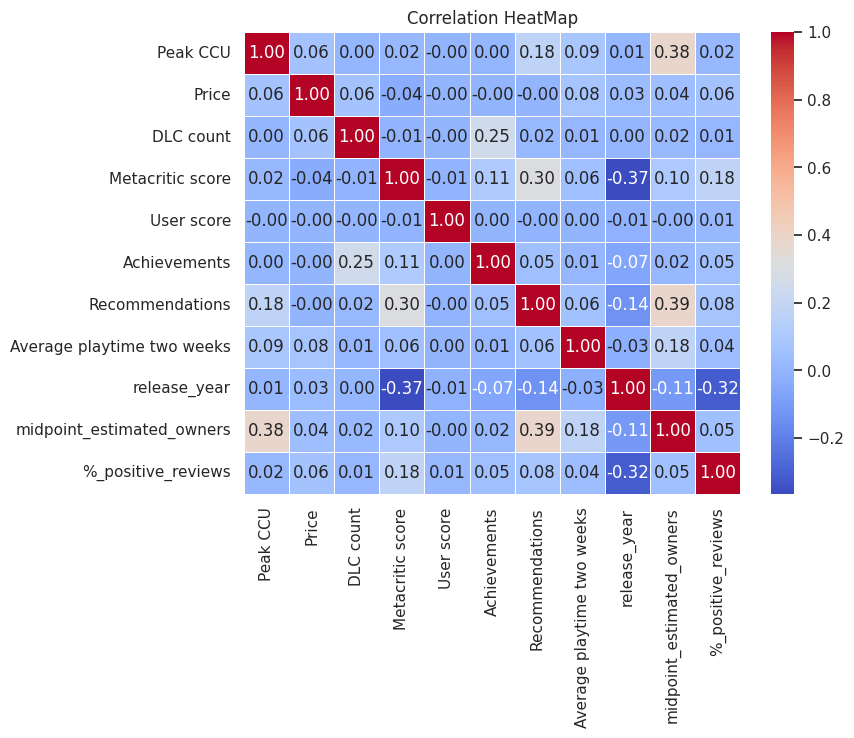

In [170]:
# Testing for Multicolinearity after Dropping Problematic Columns
steam_encoded = steam_encoded.drop(['Positive', 'Negative', 'Median playtime two weeks'], axis=1)

steam_numerical = steam_encoded[['Peak CCU','Price','DLC count','Metacritic score',
                                 'User score','Achievements','Recommendations',
                                 'Average playtime two weeks','release_year',
                                 'midpoint_estimated_owners','%_positive_reviews']]
correlation_matrix = steam_numerical.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation HeatMap')
plt.show()

This graphic shows that there is a strong relationship between positive reviews, negative reviews and recommendations. Since %_positive_reviews is just the percentage of positive reviews out of all reviews, it captures both columns. And recommendations is just how many people would recommend the game to someone else, which is also going to be highly tied to those who give it positive reviews. We can cut the positive and negative columns since the purpose of them is essentially captured by the %_positive and recommendations columns

We also need to drop one of average and median playtime. Which makes sense. We choose to drop median and make average our response variate.

Dropping these 3 columns fixes our multicolinearity.


In [171]:
#dropping na values
steam_clean = steam_encoded.dropna()
print("Dataset size before dropping na values", steam_encoded.shape)
print("Dataset size after dropping na values", steam_clean.shape)

pd.DataFrame(steam_clean).to_csv("/content/drive/MyDrive/CP322/steam_clean.csv", index=False)

Dataset size before dropping na values (113778, 94)
Dataset size after dropping na values (113132, 94)


We can do this because we lose ~2% of our data. It's so minial and still leaves us with over 110000 entries, so it's fine to cut

#2. Breadth Component

In [172]:
# loading the dataset (originally from https://www.kaggle.com/datasets/imohtn/video-games-rating-by-esrb)

path2 = "/content/drive/MyDrive/CP322/ESRB.csv" # save to github: notebooks/steamDataCleanse.ipynb
esrb = pd.read_csv(path2, index_col=False)
esrb.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [173]:
# Cleaning the ESRB dataset and enforcing Integer values
esrb_clean = esrb.dropna()
esrb_clean = esrb_clean.drop(['console'], axis=1)
print("Dataset size before dropping na values", esrb_clean.shape)

cols = esrb_clean.columns[1:32]
esrb_clean[cols] = esrb_clean[cols].astype(int)

print("Dataset size after dropping na values", esrb_clean.shape)

esrb_clean.head()

Dataset size before dropping na values (1895, 33)
Dataset size after dropping na values (1895, 33)


,title,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,T


In attempting to clean the data we see that there are no missing values at all. We drop 'console' since ratings don't vary by console and since the steam dataset already captures this. Then we enforce that all remaining columns (except ESRB rating) are integer so they can be treated as categorical columns

In [174]:
# Merging the Two Datasets by Suing Fuzzy Matching
import pandas as pd
from rapidfuzz import process, fuzz

df = steam_clean.copy()
df['Name'] = df['Name'].astype(str)
esrb_clean['title'] = esrb_clean['title'].astype(str)

query_list = df['Name'].tolist()
choices_list = esrb_clean['title'].tolist()

# Compute all similarity scores (matrix of shape len(df) x len(esrb_clean))
scores_matrix = process.cdist(
    query_list,
    choices_list,
    scorer=fuzz.ratio,
    workers=-1
)

scores_matrix = np.array(scores_matrix)

# Find index of best match for each query
best_match_idx = scores_matrix.argmax(axis=1)

# Find the corresponding best score
best_scores = scores_matrix.max(axis=1)

threshold = 84.5  # minimum score to consider a match
best_scores_masked = np.where(best_scores >= threshold, best_scores, np.nan)
best_match_idx_masked = np.where(best_scores >= threshold, best_match_idx, np.nan)

best_matches = [choices_list[int(idx)] if not np.isnan(idx) else np.nan for idx in best_match_idx_masked]

df['join_key'] = best_matches
df['match_score'] = best_scores_masked

df_merged = df.merge(
    esrb_clean,
    how='left',
    left_on='join_key',
    right_on='title'
)

print("Successfully matched IDs:", df_merged.dropna().shape[0])
print("Total IDs to Match:", esrb_clean.shape[0])

Successfully matched IDs: 1895
Total IDs to Match: 1895


We can see that all entries in the ESRB dataset have been fuzzy matched to the Steam dataset.

In [175]:
# Outputting the Merged Dataset for Records
pd.DataFrame(df_merged).to_csv("/content/drive/MyDrive/CP322/steam_esrb_merged.csv", index=False)

# 3. Dependent Variable Imbalance

In [176]:
# Replacing the Missing ESRB Values with the Mode (by ESRB Rating)
def fast_mode(df, key_cols, value_col):
    return (df.groupby(key_cols + [value_col]).size()
              .to_frame('counts').reset_index()
              .sort_values('counts', ascending=False)
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

df.loc[df.SIK.isnull(), 'SIK'] = df.CIK.map(fast_mode(df, ['CIK'], 'SIK').set_index('CIK').SIK)

AttributeError: 'DataFrame' object has no attribute 'CIK'

We want to make sure that our dataset makes sense. Noticed that when we dropped the peak players = 0 and average hours = 0, we lost 99% of our data. Not good. So we needed to come up with something else to process this.

In [ ]:
print(steam_encoded.shape)
print(steam_encoded.dropna().shape)
print((steam_encoded[steam_encoded['Average playtime two weeks'] != 0]).shape)

In [ ]:
# Dropping Rows & Columns that don't make sense in context
steam_played = steam_encoded[steam_encoded['Peak CCU'] != 0]
# if games aren't being played, then ESRB is not going to rate them

steam_played = steam_played.drop(['360 Video','Accounting','Animation & Modeling',
                                  'Audio Production','Documentary','Early Access',
                                  'Free to Play','Game Development',
                                  'Gore','Massively Multiplayer','Movie','Nudity',
                                  'Photo Editing','Sexual Content','Short',
                                  'Software Training','Tutorial','Utilities',
                                  'Video Production','Violent','Web Publishing'
                                  ], axis=1)
# these were classified as genres, but they aren't actually among what's generally considered to be genres
# maybe we keep Gore, Nudity, Sexual Content, and Violent?
# or maybe we keep them all anyways?

print("Dataframe size before dropping NA values", steam_played.shape)
steam_cleansed = steam_played.dropna()
print("Dataframe size after dropping NA values", steam_cleansed.shape)

we lose ~2% of our usable data when we drop na values. Since it's such a small amount. Since it's such a small amount and still leaves us with a good amount, it's worth it to just drop them rather than to try and impute values which may or may not be correct.

#4. Classification: Will it be Played?